---
---


# Credit Card Fraud Prediction

# #Determines
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where it has **492 frauds** out of **284,807** transactions. The dataset is **highly unbalanced**, the positive class (frauds) account for 0.172% of all transactions.

**Feature Information:**

**Time**: This feature is contains the seconds elapsed between each transaction and the first transaction in the dataset.

**Amount**:  This feature is the transaction Amount, can be used for example-dependant cost-senstive learning.

**Class**: This feature is the target variable and it takes value 1 in case of fraud and 0 otherwise.

---

The aim of this project is to predict whether a credit card transaction is fraudulent. Of course, this is not easy to do.
First of all, you need to analyze and recognize your data well in order to draw your roadmap and choose the correct arguments you will use. Accordingly, you can examine the frequency distributions of variables. You can observe variable correlations and want to explore multicollinearity. You can display the distribution of the target variable's classes over other variables.
Also, it is useful to take missing values and outliers.

After these procedures, you can move on to the model building stage by doing the basic data pre-processing you are familiar with.

Start with Logistic Regression and evaluate model performance. You will apply the Unbalanced Data Techniques used to increase the performance. Next, observe their effects.

Then, you will use four different algorithms in the model building phase.

In the final step, you will deploy your model using ***Streamlit API***.

---
---


# #Tasks

#### 1. Exploratory Data Analysis & Data Cleaning

- Import Modules, Load Data & Data Review
- Apply data integrity checks
- Exploratory Data Analysis
- Data Cleaning
    
#### 2. Data Preprocessing

- Train - Test Split
- Train - Test Split Validation Checks
- Scaling

#### 3. Model Building

- Logistic Regression
- Random Forest Classifier
- XGBoost Classifier
- Neural Network
-

#### 4. Model Deployement

- Save and Export the Best Model
- Save and Export Variables




---
---


In [ ]:
# !pip install livelossplot

## 1. Exploratory Data Analysis & Data Cleaning

### Import Modules, Load Data & Data Review

In [ ]:
# libraries for EDA
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf

# Enabling the offline mode for interactive plotting locally
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

# To display the plots
%matplotlib inline

# sklearn library for machine learning algorithms, data preprocessing, and evaluation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, RocCurveDisplay, f1_score, recall_score, precision_score, confusion_matrix, classification_report, matthews_corrcoef

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

# Importing libraries for DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, ActivityRegularization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from livelossplot import PlotLossesKerasTF

#  Display options
# plt.rcParams["figure.figsize"] = (20,6)
# pd.set_option('max_colwidth',200)
# pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# to get rid of the warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# read the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# df = pd.read_csv('creditcard.csv')
df = pd.read_csv('/content/drive/MyDrive/fraud-detection/creditcard.csv')

In [ ]:
# create a deep copy
df0 = df.copy()

In [ ]:
class OutlierCapping(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor
        self.lower_bound = None
        self.upper_bound = None

    def fit(self, X, y=None):
        X = X # pd.DataFrame(X)
        self.lower_bound = X.quantile(0.25) - self.factor * (X.quantile(0.75) - X.quantile(0.25))
        self.upper_bound = X.quantile(0.75) + self.factor * (X.quantile(0.75) - X.quantile(0.25))
        return self

    def transform(self, X, y=None):
        X = X # pd.DataFrame(X)
        X_capped = X.clip(lower=self.lower_bound, upper=self.upper_bound, axis=1)
        return X_capped

#### Autoencoder Anomaly Detection

***i. Import Libraries***

In [ ]:
df_anomaly = df0[df0.Class == 1]
df_normal = df0[df0.Class == 0]

In [ ]:
# Removing Time columns because of the cardinality.
df_normal.drop(columns=['Time'],inplace=True)
df_anomaly.drop(columns=['Time'],inplace=True)

In [ ]:
display(df_normal.shape)
df_normal.drop_duplicates(inplace=True)
df_normal.reset_index(drop=True,inplace=True)
display(df_normal.shape)

display(df_anomaly.shape)
df_anomaly.drop_duplicates(inplace=True)
df_anomaly.reset_index(drop=True,inplace=True)
display(df_anomaly.shape)

(284315, 30)

(275190, 30)

(492, 30)

(473, 30)

In [ ]:
# Applying log transformation to the Amount column since it is highly right-skewed.
# We are using np.log1p since the Amount column minimum is 0.
display(df_normal.Amount.skew())
df_normal['Amount'] = np.log1p(df_normal['Amount'])
display(df_normal.Amount.skew())

16.866718730563512

0.1395260148138248

In [ ]:
display(df_anomaly.Amount.skew())
df_anomaly['Amount'] = np.log1p(df_anomaly['Amount'])
display(df_anomaly.Amount.skew())

3.7244782527095226

0.30783741384828084

In [ ]:
# We only use non_fraud data to train our Autoencoder
# split the features and target
X = df_normal.drop('Class', axis=1)
y = df_normal['Class'].values

In [ ]:
# split the data as train, validation and test data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    # stratify=y,
                                                    test_size=0.15,
                                                    random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  # stratify=y_train,
                                                  test_size=0.1,
                                                  random_state=42)

In [ ]:
capper = OutlierCapping(factor=3)
# scale the data; fit_transform for train, transform val and test
X_train = capper.fit_transform(X_train)
X_val = capper.transform(X_val)
X_test = capper.transform(X_test)

In [ ]:
# RobutScaler and StandardScaler did not give good results.
scaler = MinMaxScaler()
# scale the data; fit_transform for train, transform val and test
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
X_anomaly = df_anomaly.drop('Class', axis=1)

In [ ]:
X_anomaly = capper.transform(X_anomaly)
X_anomaly = scaler.transform(X_anomaly)

***ii. Define Model***

In [ ]:
class AnomalyDetector(tf.keras.Model):
    """
    Autoencoder model.

    Args:
        n_features: The number of features in the input data.
    """

    def __init__(self, n_features):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation="elu", name="encoder_2"),
            tf.keras.layers.Dense(32, activation="elu", name="encoder_3"),
            tf.keras.layers.Dense(16, activation="elu", name="encoder_4"),
            tf.keras.layers.Dense(8, activation="elu", name="encoder_5"),
            ActivityRegularization(l1=1e-3)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(8, activation="elu", name="decoder_1"),
            tf.keras.layers.Dense(16, activation="elu", name="decoder_2"),
            tf.keras.layers.Dense(32, activation="elu", name="decoder_3"),
            tf.keras.layers.Dense(64, activation="elu", name="decoder_4"),
            tf.keras.layers.Dense(n_features, activation="relu", name="decoder_5"),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
class AnomalyDetector2(tf.keras.Model):
    def __init__(self, n_features):
        super(AnomalyDetector2, self).__init__()
        self.encoder = tf.keras.Sequential([
            Dense(16, activation="elu"),
            Dense(8, activation="elu"),
            Dense(4, activation="elu"),
            Dense(2, activation="elu"),
            ActivityRegularization(l1=1e-3)])

        self.decoder = tf.keras.Sequential([
            Dense(2, activation="elu"),
            Dense(4, activation="elu"),
            Dense(8, activation="elu"),
            Dense(16, activation="elu"),
            Dense(n_features, activation="elu")])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
n_features = len(X.columns)

In [ ]:
n_features

29

In [ ]:
autoencoder = AnomalyDetector(n_features)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

***iii. Compile Model***

In [ ]:
autoencoder.compile(
    optimizer=opt,
    loss="mean_squared_error")
earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

***iv. Fit Model***

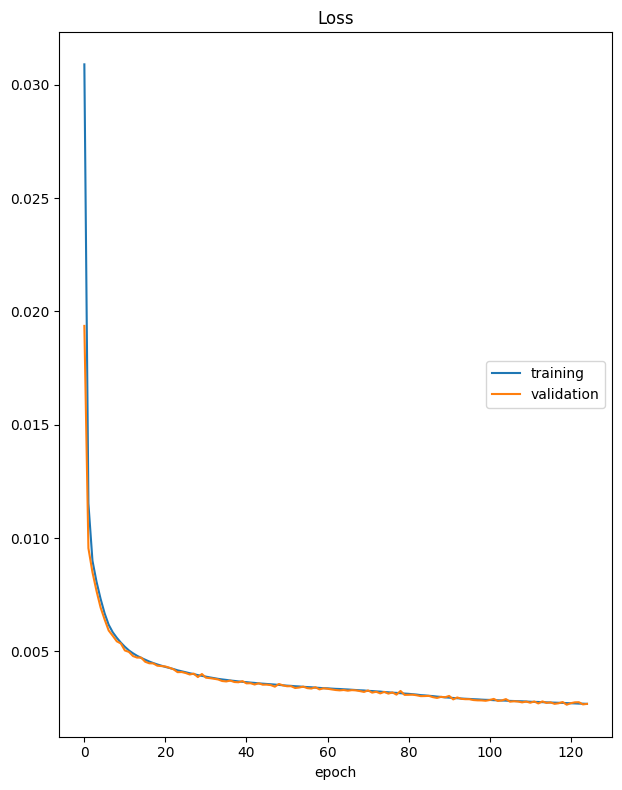

Loss
	training         	 (min:    0.003, max:    0.031, cur:    0.003)
	validation       	 (min:    0.003, max:    0.019, cur:    0.003)
1645/1645 [==============================] - 8s 5ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 125: early stopping


In [ ]:
history = autoencoder.fit(
        X_train,
        X_train,
        epochs=1000,
        batch_size=128,
        validation_data=(X_val, X_val),
        verbose = 1,
        callbacks=[earlystopper, PlotLossesKerasTF()],
        shuffle=True)

***v. Prediction and Model Evaluating***

<Axes: >

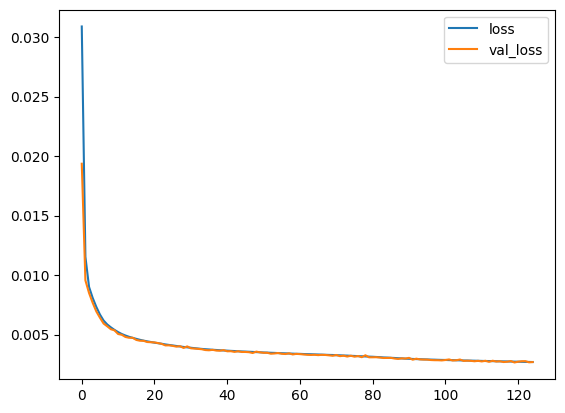

In [ ]:
loss_df = pd.DataFrame(autoencoder.history.history)
loss_df.plot()

In [ ]:
train_data_predictions = autoencoder.predict(X_train)   # predict reconstruction
mse_train = np.mean(np.power(X_train- train_data_predictions, 2), axis=1)   # calculates MSE between test data and reconstruction

6579/6579 [==============================] - 12s 2ms/step


In [ ]:
test_data_predictions = autoencoder.predict(X_test)   # predict reconstruction
mse_test = np.mean(np.power(X_test- test_data_predictions, 2), axis=1)   # calculates MSE between test data and reconstruction

1290/1290 [==============================] - 2s 2ms/step


In [ ]:
anomaly_data_predictions = autoencoder.predict(X_anomaly)   # predict reconstruction
mse_anomaly = np.mean(np.power(X_anomaly - anomaly_data_predictions, 2), axis=1)   # calculates MSE between anomaly data and reconstruction

15/15 [==============================] - 0s 2ms/step


In [ ]:
df_mse_train = pd.DataFrame(mse_train)
df_mse_train['Class'] = 0

In [ ]:
df_mse_test = pd.DataFrame(mse_test)
df_mse_test['Class'] = 0

In [ ]:
df_mse_anomaly = pd.DataFrame(mse_anomaly)
df_mse_anomaly['Class'] = 1

##### Train - Anomaly

In [ ]:
df_autoencoder_predictions = pd.concat([df_mse_anomaly,df_mse_train])

In [ ]:
df_autoencoder_predictions.reset_index(drop=True,inplace=True)
df_autoencoder_predictions.rename(columns={0: 'MSE'}, inplace=True)

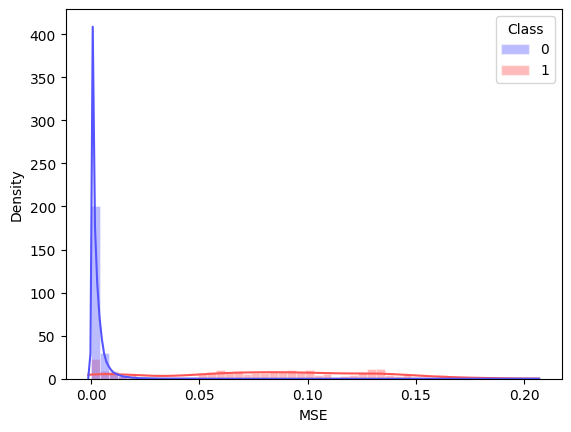

In [ ]:
sns.histplot(df_autoencoder_predictions, x='MSE', bins=50, hue='Class', stat='density', common_norm=False, kde=True, kde_kws=dict(cut=3), alpha=.4, palette='seismic', edgecolor=(1, 1, 1, .4));


<Axes: xlabel='Class', ylabel='MSE'>

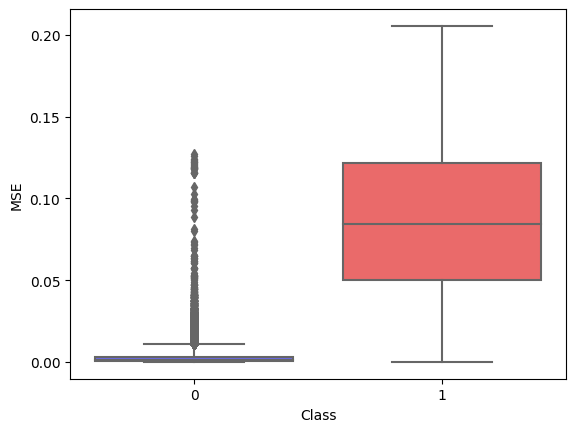

In [ ]:
 sns.boxplot(x="Class", y='MSE', data=df_autoencoder_predictions, palette='seismic', whis =3)

In [ ]:
np.percentile(mse_anomaly,5)

0.0020176895850855035

In [ ]:
import plotly.graph_objects as go

# Generate thresholds
thresholds = np.linspace(0, mse_anomaly.mean(), num=150)

# Calculate AP, precision, and recall scores for each threshold
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    df_autoencoder_predictions['predicted'] = df_autoencoder_predictions['MSE'].apply(lambda x: 1 if x > threshold else 0)
    y_true = df_autoencoder_predictions['Class']
    y_pred = df_autoencoder_predictions['predicted']

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

df_scores = pd.DataFrame({'Threshold': thresholds,
                          'F1 Score': f1_scores,
                          'Precision': precision_scores,
                          'Recall': recall_scores})

In [ ]:

# Create line plot using graph_objects
fig = go.Figure()

fig.add_trace(go.Scatter(x=thresholds, y=f1_scores, mode='lines', name='F1 Score'))
fig.add_trace(go.Scatter(x=thresholds, y=precision_scores, mode='lines', name='Precision'))
fig.add_trace(go.Scatter(x=thresholds, y=recall_scores, mode='lines', name='Recall'))

fig.update_layout(
    title='Scores for Different Thresholds',
    xaxis_title='Threshold',
    yaxis_title='Score',
    legend=dict(x=0.7, y=0.9),
    width=800,
    height=500
)

# # Add annotation for the scores
# fig.add_annotation(
#     x=thresholds[0],  # Initial position of the annotation
#     y=f1_scores[0],
#     text=f'F1: {f1_scores[0]:.4f}, Precision: {precision_scores[0]:.4f}, Recall: {recall_scores[0]:.4f}',
#     showarrow=False,
#     font=dict(size=12)
# )

# Update the annotation position and text based on mouse hover
fig.update_layout(
    hovermode='x',
    hoverdistance=-1,  # Ensures the hover is always on the line
)

fig.update_traces(hovertemplate=None)  # Disable default hover template

fig.show(renderer='colab')

In [ ]:
# The row where the f1 score is the highest
df_scores.loc[df_scores['F1 Score'].idxmax()]

Threshold   0.048
F1 Score    0.794
Precision   0.838
Recall      0.755
Name: 90, dtype: float64

In [ ]:
optimal_threshold = df_scores.loc[df_scores['F1 Score'].idxmax()].Threshold

In [ ]:
df_autoencoder_predictions['predicted'] = df_autoencoder_predictions['MSE'].apply(lambda x: 1 if x > optimal_threshold else 0)

In [ ]:
y_true = df_autoencoder_predictions['Class']
y_pred = df_autoencoder_predictions['predicted']

In [ ]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(matthews_corrcoef(y_true, y_pred))

[[210450     69]
 [   116    357]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    210519
           1       0.84      0.75      0.79       473

    accuracy                           1.00    210992
   macro avg       0.92      0.88      0.90    210992
weighted avg       1.00      1.00      1.00    210992



***vi. Plot Precision and Recall Curve***

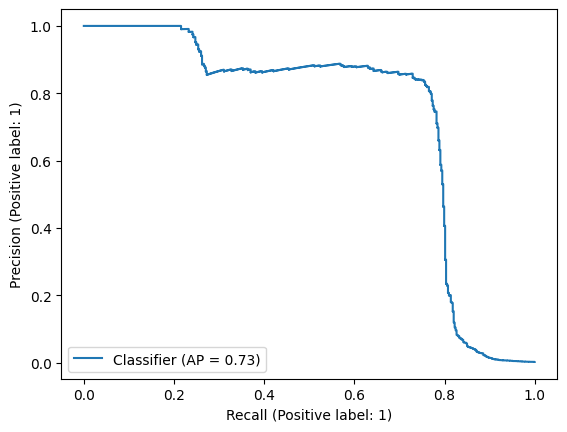

In [ ]:
PrecisionRecallDisplay.from_predictions(y_true,df_autoencoder_predictions['MSE'])

##### Test - Anomaly

In [ ]:
df_autoencoder_predictions = pd.concat([df_mse_anomaly,df_mse_test])

In [ ]:
df_autoencoder_predictions.reset_index(drop=True,inplace=True)
df_autoencoder_predictions.rename(columns={0: 'MSE'}, inplace=True)

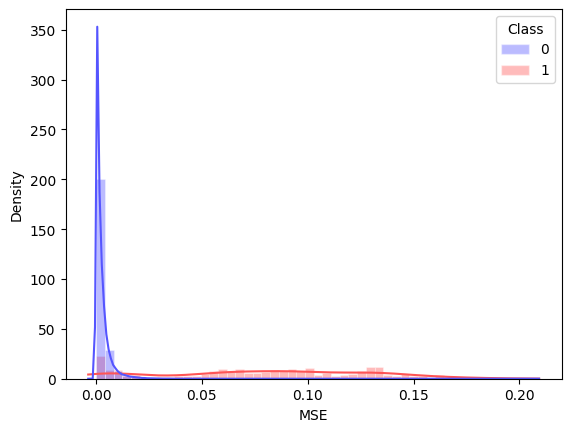

In [ ]:
sns.histplot(df_autoencoder_predictions, x='MSE', bins=50, hue='Class', stat='density', common_norm=False, kde=True, kde_kws=dict(cut=3), alpha=.4, palette='seismic', edgecolor=(1, 1, 1, .4));


<Axes: xlabel='Class', ylabel='MSE'>

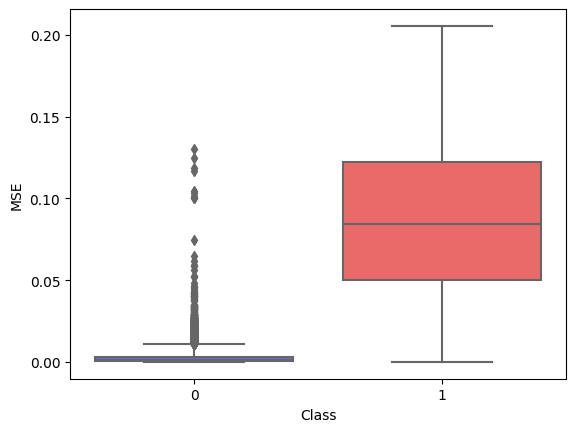

In [ ]:
 sns.boxplot(x="Class", y='MSE', data=df_autoencoder_predictions, palette='seismic', whis =3)

In [ ]:
df_autoencoder_predictions['predicted'] = df_autoencoder_predictions['MSE'].apply(lambda x: 1 if x > optimal_threshold else 0)

In [ ]:
y_true = df_autoencoder_predictions['Class']
y_pred = df_autoencoder_predictions['predicted']

In [ ]:
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))
print(matthews_corrcoef(y_true, y_pred))

[[41262    17]
 [  116   357]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     41279
           1       0.95      0.75      0.84       473

    accuracy                           1.00     41752
   macro avg       0.98      0.88      0.92     41752
weighted avg       1.00      1.00      1.00     41752

0.847314511213861


***vi. Plot Precision and Recall Curve***

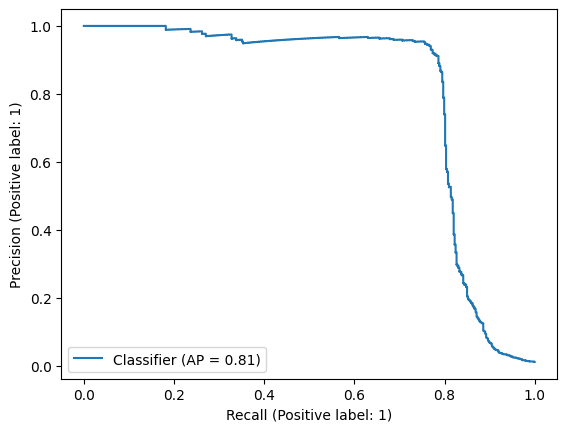

In [ ]:
PrecisionRecallDisplay.from_predictions(y_true,df_autoencoder_predictions['MSE'])

##### Model Deployment

In [ ]:
autoencoder.save_weights('model_autoencoder.h5')

In [ ]:
autoencoder.save('model_autoencoder_tf',save_format='tf')

In [ ]:
import pickle
scalerfile = 'autoencoder_scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [ ]:
capperfile = 'autoencoder_capping'
pickle.dump(capper, open(capperfile, 'wb'))

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('model_autoencoder_tf')

In [ ]:
# Load the scaler
scalerfile = 'autoencoder_scaler.sav'
scaler = pickle.load(open(scalerfile, 'rb'))

# Use the loaded scaler for scaling new data
# scaled_data = scaler.transform(new_data)

In [ ]:
# Load the capper object
capperfile = 'autoencoder_capping'
capper = pickle.load(open(capperfile, 'rb'))

In [ ]:
sample = pd.DataFrame(df_anomaly.iloc[3].drop('Class')).T
sample

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
3,-4.398,1.358,-2.593,2.680,-1.128,-1.707,-3.496,-0.249,-0.248,-4.802,4.896,-10.913,0.184,-6.771,-0.007,-7.358,-12.598,-5.132,0.308,-0.172,0.574,0.177,-0.436,-0.054,0.252,-0.657,-0.827,0.850,4.094


In [ ]:
sample = capper.transform(sample)
sample

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
3,-4.398,1.358,-2.593,2.680,-1.128,-1.707,-3.496,-0.249,-0.248,-3.564,4.896,-3.494,0.184,-3.173,-0.007,-3.475,-3.121,-3.516,0.308,-0.172,0.574,0.177,-0.436,-0.054,0.252,-0.657,-0.569,0.483,4.094


In [ ]:
sample = scaler.transform(sample)
sample

array([[0.32239728, 0.62528128, 0.29540505, 0.74293611, 0.3814471 ,
        0.31176924, 0.05768106, 0.41784878, 0.47496541, 0.        ,
        0.96554637, 0.        , 0.51890901, 0.        , 0.49672751,
        0.        , 0.        , 0.        , 0.54740343, 0.44507092,
        0.70451883, 0.52361639, 0.30365536, 0.48389588, 0.55129034,
        0.34671978, 0.        , 1.        , 0.40322713]])

In [ ]:
sample_data_predictions = loaded_model.predict(sample)   # predict reconstruction
mse_sample = np.mean(np.power(sample- sample_data_predictions, 2), axis=1)   # calculates MSE between test data and reconstruction

1/1 [==============================] - 0s 129ms/step


In [ ]:
error_df = pd.DataFrame(mse_sample,columns=['reconstruction_error'])

In [ ]:
error_df['y_pred'] = error_df['reconstruction_error'].apply(lambda x: 1 if x > optimal_threshold else 0)

In [ ]:
error_df

,reconstruction_error,y_pred
0,0.106,1


___

<p style="text-align: center;"><img src="https://docs.google.com/uc?id=1lY0Uj5R04yMY3-ZppPWxqCr5pvBLYPnV" class="img-fluid" alt="CLRSWY"></p>

___